### Transformer Basic Code
### Paper Title: Attention is All You Need
##### Paper Link: https://arxiv.org/pdf/1706.03762.pdf

In [1]:
# Import required libraries
from torch import Tensor
import torch.nn.functional as f
import torch
from torch import nn
# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%reload_ext autoreload
%autoreload 2
%matplotlib inline

C:\Users\User\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\User\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\User\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


Transformers use a specific type of attention mechanism called "multi-head attention." 

Understand Transformers is really easy once we understand the multi-head attention. 

An illustration of attention and multi-head attention taken from the original paper is given below.

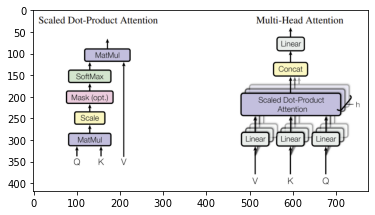

In [2]:
plt.imshow(mpimg.imread('Attention.png'))

We start with "scaled dot-product attention", since we also need it to build the multi-head attention layer. Mathematically, it is expressed as: 

$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$

Where queries $Q$, keys $K$, and values $V$ are batches of matrices, each with shape (batch_size, seq_length, num_features); $d_k$ is the dimension of queries $Q$ and keys $K$; $T$ referes to transpose. 

Multiplying the query (Q) and key (K) results in a shape of (batch_size, seq_length, seq_length), which tells us roughly how important each element in the sequence is. This is the attention of this layer — it determines which elements we “pay attention” to. 

The attention array is normalized using softmax, so that all of the weights sum to one. 

Finally, the attention is applied to the value (V) using matrix multiplication.

P.N. For simplicity, we omit the optional Mask operation as shown in the above figure.

In the following code the MatMul operations are translated to torch.bmm in PyTorch. That's because Q, K, and V (query, key, and value arrays) are batches of matrices, each with shape (batch_size, sequence_length, num_features). Batch matrix multiplication is only performed over the last two dimensions.

In [3]:
def scaled_dot_product_attention(query: Tensor, key: Tensor, value: Tensor) -> Tensor:
    temp = query.bmm(key.transpose(1, 2))
    scale = query.size(-1) ** 0.5
    softmax = f.softmax(temp / scale, dim=-1)
    return softmax.bmm(value)

From the diagram above, we see that multi-head attention is composed of several identical attention heads. Each attention head contains 3 linear layers, followed by scaled dot-product attention. Let's encapsulate this in an AttentionHead layer.

In [4]:
class AttentionHead(nn.Module):
    def __init__(self, dim_in: int, dim_k: int, dim_v: int):
        super().__init__()
        self.q = nn.Linear(dim_in, dim_k)
        self.k = nn.Linear(dim_in, dim_k)
        self.v = nn.Linear(dim_in, dim_v)

    def forward(self, query: Tensor, key: Tensor, value: Tensor) -> Tensor:
        return scaled_dot_product_attention(self.q(query), self.k(key), self.v(value))

Now, it's very easy to build the multi-head attention layer. Just combine num_heads different attention heads and a Linear layer for the output.

Each attention head computes its own query, key, and value matrices, and then applies scaled dot-product attention. Conceptually, this means each head can attend to a different part of the input sequence, independent of the others. Increasing the number of attention heads allows us to "pay attention" to more parts of the sequence at once, which makes the model more powerful.

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads: int, dim_in: int, dim_k: int, dim_v: int):
        super().__init__()
        self.heads = nn.ModuleList(
            [AttentionHead(dim_in, dim_k, dim_v) for _ in range(num_heads)]
        )
        self.linear = nn.Linear(num_heads * dim_v, dim_in)

    def forward(self, query: Tensor, key: Tensor, value: Tensor) -> Tensor:
        return self.linear(
            torch.cat([h(query, key, value) for h in self.heads], dim=-1)
        )

We need one more component before building the complete transformer: positional encoding. Notice that MultiHeadAttention has no trainable components that operate over the sequence dimension (axis 1). Everything operates over the feature dimension (axis 2), and so it is independent of sequence length. We have to provide positional information to the model, so that it knows about the relative position of data points in the input sequences.

Vaswani et. al. encode positional information using trigonometric functions, according to the equation:

$PE_{(pos, 2i)} = sin(pos/10000^{2i/d_{model}})$

$PE_{(pos, 2i+1)} = cos(pos/10000^{2i/d_{model}})$


According to the authors 

    We also experimented with using learned positional embeddings instead, and found that the two versions produced nearly identical results. We chose the sinusoidal version because it may allow the model to extrapolate to sequence lengths longer than the ones encountered during training.
    
Why should sinusoidal encodings extrapolate to longer sequence lengths? Because sine/cosine functions are periodic, and they cover a range of [0, 1]. Most other choices of encoding would not be periodic or restricted to the range [0, 1]. Suppose that, during inference, you provide an input sequence longer than any used during training. Positional encoding for the last elements in the sequence could be different than anything the model has seen before. For those reasons, and despite the fact that learned embeddings appeared to perform equally as well, the authors still chose to use sinusoidal encoding. (I personally prefer learned embeddings, because they’re easier to implement and debug. But we’ll follow the authors for this article.)

In [6]:
def position_encoding(seq_len: int, dim_model: int, device: torch.device = torch.device("cpu"),) -> Tensor:
    pos = torch.arange(seq_len, dtype=torch.float, device=device).reshape(1, -1, 1)
    dim = torch.arange(dim_model, dtype=torch.float, device=device).reshape(1, 1, -1)
    phase = (pos / 1e4) ** (dim // dim_model)

    return torch.where(dim.long() % 2 == 0, torch.sin(phase), torch.cos(phase))

Finally, we’re ready to build the Transformer! Let’s take a look at the complete network diagram.

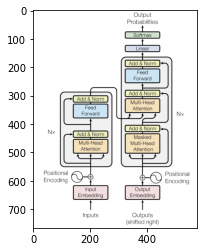

In [7]:
plt.imshow(mpimg.imread('Transformer.png'))

Notice that the transformer uses an encoder-decoder architecture. The encoder (left) processes the input sequence and returns a feature vector (or memory vector). The decoder processes the target sequence, and incorporates information from the encoder memory. The output from the decoder is our model’s prediction!

We can code the encoder/decoder modules independently of one another, and then combine them at the end. But first we need a few more pieces of information, which aren’t included in the figure above. For example, how should we choose to build the feed forward networks?

    Each of the layers in our encoder and decoder contains a fully connected feed-forward network, which … consists of two linear transformations with a ReLU activation in between. The dimensionality of input and output is 512, and the inner-layer has dimensionality 2048.
    
This gives a simple implementation for the Feed Forward modules above:

In [8]:
def feed_forward(dim_input: int = 512, dim_feedforward: int = 2048) -> nn.Module:
    return nn.Sequential(
        nn.Linear(dim_input, dim_feedforward),
        nn.ReLU(),
        nn.Linear(dim_feedforward, dim_input),
    )

What kind of normalization should be used? Do we need any regularization, such as dropout layers?
    
    The output of each sub-layer is LayerNorm(x + Sublayer(x)), where Sublayer(x) is the function implemented by the sub-layer itself. … We apply dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized.

We can encapsulate all of this in a Module:

In [9]:
class Residual(nn.Module):
    def __init__(self, sublayer: nn.Module, dimension: int, dropout: float = 0.1):
        super().__init__()
        self.sublayer = sublayer
        self.norm = nn.LayerNorm(dimension)
        self.dropout = nn.Dropout(dropout)

    def forward(self, *tensors: Tensor) -> Tensor:
        # Assume that the "value" tensor is given last, so we can compute the
        # residual.  This matches the signature of 'MultiHeadAttention'.
        return self.norm(tensors[-1] + self.dropout(self.sublayer(*tensors)))

Time to dive in and create the encoder. Using the utility methods we just built, this is pretty easy.

In [10]:
class TransformerEncoderLayer(nn.Module):
    def __init__(
        self, 
        dim_model: int = 512, 
        num_heads: int = 6, 
        dim_feedforward: int = 2048, 
        dropout: float = 0.1, 
    ):
        super().__init__()
        dim_k = dim_v = dim_model // num_heads
        self.attention = Residual(
            MultiHeadAttention(num_heads, dim_model, dim_k, dim_v),
            dimension=dim_model,
            dropout=dropout,
        )
        self.feed_forward = Residual(
            feed_forward(dim_model, dim_feedforward),
            dimension=dim_model,
            dropout=dropout,
        )

    def forward(self, src: Tensor) -> Tensor:
        src = self.attention(src, src, src)
        return self.feed_forward(src)


class TransformerEncoder(nn.Module):
    def __init__(
        self, 
        num_layers: int = 6,
        dim_model: int = 512, 
        num_heads: int = 8, 
        dim_feedforward: int = 2048, 
        dropout: float = 0.1, 
    ):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(dim_model, num_heads, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, src: Tensor) -> Tensor:
        seq_len, dimension = src.size(1), src.size(2)
        src += position_encoding(seq_len, dimension)
        for layer in self.layers:
            src = layer(src)

        return src

The decoder module is extremely similar. Just a few small differences:

1. The decoder accepts two arguments (target and memory), rather than one.
2. There are two multi-head attention modules per layer, instead of one.
3. The second multi-head attention accepts memory for two of its inputs.

In [11]:
class TransformerDecoderLayer(nn.Module):
    def __init__(
        self, 
        dim_model: int = 512, 
        num_heads: int = 6, 
        dim_feedforward: int = 2048, 
        dropout: float = 0.1, 
    ):
        super().__init__()
        dim_k = dim_v = dim_model // num_heads
        self.attention_1 = Residual(
            MultiHeadAttention(num_heads, dim_model, dim_k, dim_v),
            dimension=dim_model,
            dropout=dropout,
        )
        self.attention_2 = Residual(
            MultiHeadAttention(num_heads, dim_model, dim_k, dim_v),
            dimension=dim_model,
            dropout=dropout,
        )
        self.feed_forward = Residual(
            feed_forward(dim_model, dim_feedforward),
            dimension=dim_model,
            dropout=dropout,
        )

    def forward(self, tgt: Tensor, memory: Tensor) -> Tensor:
        tgt = self.attention_1(tgt, tgt, tgt)
        tgt = self.attention_2(memory, memory, tgt)
        return self.feed_forward(tgt)


class TransformerDecoder(nn.Module):
    def __init__(
        self, 
        num_layers: int = 6,
        dim_model: int = 512, 
        num_heads: int = 8, 
        dim_feedforward: int = 2048, 
        dropout: float = 0.1, 
    ):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerDecoderLayer(dim_model, num_heads, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])
        self.linear = nn.Linear(dim_model, dim_model)

    def forward(self, tgt: Tensor, memory: Tensor) -> Tensor:
        seq_len, dimension = tgt.size(1), tgt.size(2)
        tgt += position_encoding(seq_len, dimension)
        for layer in self.layers:
            tgt = layer(tgt, memory)

        return torch.softmax(self.linear(tgt), dim=-1)

Lastly, we need to wrap everything up into a single Transformer class. This requires minimal work, because it’s nothing new — just throw an encoder and decoder together, and pass data through them in the correct order.

In [12]:
class Transformer(nn.Module):
    def __init__(
        self, 
        num_encoder_layers: int = 6,
        num_decoder_layers: int = 6,
        dim_model: int = 512, 
        num_heads: int = 6, 
        dim_feedforward: int = 2048, 
        dropout: float = 0.1, 
        activation: nn.Module = nn.ReLU(),
    ):
        super().__init__()
        self.encoder = TransformerEncoder(
            num_layers=num_encoder_layers,
            dim_model=dim_model,
            num_heads=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.decoder = TransformerDecoder(
            num_layers=num_decoder_layers,
            dim_model=dim_model,
            num_heads=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )

    def forward(self, src: Tensor, tgt: Tensor) -> Tensor:
        return self.decoder(tgt, self.encoder(src))

And we’re done! Let’s create a simple test, as a sanity check for our implementation. We can construct random tensors for src and tgt, check that our model executes without errors, and confirm that the output tensor has the correct shape.

In [13]:
src = torch.rand(64, 16, 512)
tgt = torch.rand(64, 16, 512)
out = Transformer()(src, tgt)
print(out.shape)
# torch.Size([64, 16, 512])

torch.Size([64, 16, 512])


Code Reference: https://medium.com/the-dl/transformers-from-scratch-in-pytorch-8777e346ca51